In [35]:
import pandas as pd
import numpy as np
from collections import Counter
#from tqdm.notebook import tqdm
from imblearn.under_sampling import RandomUnderSampler

import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from transformers import DataCollatorWithPadding
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [36]:
from datasets import load_dataset
from transformers import AutoTokenizer

ds = load_dataset("AbrilCota/moviesData")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [37]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'reviewId', 'creationDate', 'criticName', 'isTopCritic', 'originalScore', 'reviewState', 'publicatioName', 'reviewText', 'scoreSentiment', 'reviewUrl'],
        num_rows: 1444963
    })
})

In [38]:
ds['train'] = ds['train'].select_columns(['reviewText','scoreSentiment'])
ds = ds.rename_column('scoreSentiment','labels')
ds

DatasetDict({
    train: Dataset({
        features: ['reviewText', 'labels'],
        num_rows: 1444963
    })
})

In [39]:
def replace_label(row):
  row['labels'] = 1 if row['labels'] == "POSITIVE" else 0
  return row

In [40]:
ds = ds.map(replace_label)

In [41]:
split = ds['train'].train_test_split(test_size=0.2, shuffle=True, seed=42)

ds_train = split['train']
ds_test = split['test']

In [42]:
split2 = ds_train.train_test_split(
    test_size=0.2,
    shuffle=True,
    seed=42
)

ds_train = split2['train']
ds_val = split2['test']

In [43]:
ds_train_small = ds_train.shuffle(seed=42).select(range(200000))
ds_val_small = ds_val.shuffle(seed=42).select(range(100000))
ds_test_small = ds_test.shuffle(seed=42).select(range(100000))

In [44]:
counts = Counter(ds_train_small['labels'])
print(counts)


Counter({1: 133632, 0: 66368})


In [45]:
def undersample(dataset, label_col="labels", seed=42):
    labels = np.array(dataset[label_col])

    class0_idx = np.where(labels == 0)[0]
    class1_idx = np.where(labels == 1)[0]

    min_count = min(len(class0_idx), len(class1_idx))

    np.random.seed(seed)
    class0_sample = np.random.choice(class0_idx, min_count, replace=False)
    class1_sample = np.random.choice(class1_idx, min_count, replace=False)

    balanced_idx = np.concatenate([class0_sample, class1_sample])
    np.random.shuffle(balanced_idx)

    balanced_dataset = dataset.select(balanced_idx.tolist())

    return balanced_dataset


In [46]:
ds_train_balanced = undersample(ds_train_small)

In [47]:
counts = Counter(ds_train_balanced['labels'])
print(counts)

Counter({0: 66368, 1: 66368})


In [48]:
def tokenization(batch):
  texts = [t if t is not None else "" for t in batch["reviewText"]]
  return tokenizer(
      texts,
      truncation=True,
      padding=False,
      max_length=256)

In [49]:
ds_train_balanced = ds_train_balanced.map(tokenization, batched=True)
ds_val_small = ds_val_small.map(tokenization, batched=True)
ds_test_small = ds_test_small.map(tokenization, batched=True)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [50]:
ds_train

Dataset({
    features: ['reviewText', 'labels'],
    num_rows: 924776
})

In [51]:
ds_train_balanced = ds_train_balanced.remove_columns(['reviewText', 'token_type_ids'])
ds_val_small = ds_val_small.remove_columns(['reviewText', 'token_type_ids'])
ds_test_small = ds_test_small.remove_columns(['reviewText', 'token_type_ids'])


In [52]:
'''
tokens_counts = Counter()

for ids in ds_train['input_ids']:
  tokens_counts.update(ids)

top_ids = tokens_counts.most_common(10)

top_ids

[(tokenizer.convert_ids_to_tokens(id), count) for id, count in top_ids]
'''

"\ntokens_counts = Counter()\n\nfor ids in ds_train['input_ids']:\n  tokens_counts.update(ids)\n\ntop_ids = tokens_counts.most_common(10)\n\ntop_ids\n\n[(tokenizer.convert_ids_to_tokens(id), count) for id, count in top_ids]\n"

In [53]:
ds_train_balanced.set_format(type="torch", columns=['input_ids', 'attention_mask','labels'])
ds_val_small.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])
ds_test_small.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

In [54]:
ds_train

Dataset({
    features: ['reviewText', 'labels'],
    num_rows: 924776
})

In [55]:
BATCH_SIZE = 32
collator = DataCollatorWithPadding(tokenizer)

In [56]:
dataloader_train = DataLoader(
    ds_train_balanced,
    batch_size=BATCH_SIZE,
    collate_fn=collator,
    #sampler=sampler,
    shuffle=True
  )
dataloader_val = DataLoader(
    ds_val_small,
    batch_size=BATCH_SIZE,
    collate_fn=collator,
    shuffle=True
  )
dataloader_test = DataLoader(
    ds_test_small,
    batch_size=BATCH_SIZE,
    collate_fn=collator,
    shuffle=True
  )

In [57]:
EMBED_DIM = 128
HIDDEN_DIM = 32
N_LAYERS = 1

class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding_layer = nn.Embedding(
        num_embeddings=len(tokenizer),
        embedding_dim=EMBED_DIM
    )
    self.rnn = nn.RNN(
        input_size=EMBED_DIM,
        hidden_size=HIDDEN_DIM,
        num_layers=N_LAYERS,
        batch_first=True
        )
    self.linear = nn.Linear(
        in_features= HIDDEN_DIM,
        out_features=1
        )

  def forward(self, input, attention_mask):                   # input → (batch, seq_len) [seq_len = number of tokens per batch (after padding)]
    embeddings = self.embedding_layer(input)                  # (batch, seq_len, EMBED_DIM)

    lengths = attention_mask.sum(dim=1).cpu()

    packed = pack_padded_sequence(
        embeddings,
        lengths,
        batch_first=True,
        enforce_sorted=False
    )

    output, final_hidden = self.rnn(packed)                   # (batch, seq_len, hidden) , (num_layers, batch, hidden)
    #final_hidden = final_hidden.squeeze(0)                   # (batch, hidden)
    return self.linear(final_hidden[-1])

In [58]:
device = torch.device('cuda')

model = TextClassifier()
model = model.to(device)

In [59]:
LR = 1e-3
EPOCHS = 5
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [60]:
def train(dataloader, device):
  model.train()

  size = len(dataloader.dataset)
  train_losses = []

  for batch in dataloader:
    data = batch['input_ids'].to(device)
    mask = batch['attention_mask'].to(device)
    label = batch['labels'].float().to(device)

    out = model(data, mask).squeeze(1)
    loss = loss_fn(out, label)

    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg_loss = sum(train_losses)/len(train_losses)

  return avg_loss




In [61]:
def val(dataloader, device):
  model.eval()

  size = len(dataloader.dataset)
  val_losses = []
  correct = 0

  with torch.no_grad():
    for batch in dataloader:
      data = batch['input_ids'].to(device)
      mask = batch['attention_mask'].to(device)
      label = batch['labels'].float().to(device)

      out = model(data, mask).squeeze(1)

      loss = loss_fn(out, label)
      val_losses.append(loss.item())

      probs = torch.sigmoid(out)
      preds = (probs > 0.5).float()
      correct += (preds == label).sum().item()

    acc = correct / size
    avg_loss = sum(val_losses)/len(val_losses)

    return avg_loss, acc

In [62]:
def test(dataloader, device):
  model.eval()

  size = len(dataloader.dataset)
  correct = 0
  losses = []

  with torch.no_grad():
    for batch in dataloader:
      data = batch['input_ids'].to(device)
      mask = batch['attention_mask'].to(device)
      label = batch['labels'].float().to(device)

      out = model(data, mask).squeeze(1)

      loss = loss_fn(out, label)
      losses.append(loss.item())

      probs = torch.sigmoid(out)
      preds = (probs > 0.5).float()
      correct += (preds == label).sum().item()

  acc = correct / size
  avg_loss = sum(losses)/len(losses)

  print(f"test accuracy: {acc*100:.1f}% | test loss: {avg_loss:.4f}")





In [63]:
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCHS):

  train_loss = train(dataloader_train, device)
  history['train_loss'].append(train_loss)

  val_loss, acc_val = val(dataloader_val, device)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(acc_val)

  print(
        f"Epoch {epoch:03d} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f} | "
        f"Val acc: {acc_val:.4f}"
    )

  if acc_val > best_val_acc:
      best_val_acc = acc_val
      torch.save(model.state_dict(), f'best_model_epoch_{epoch+1}.pt')
      print(f"Model saved: best_model_epoch_{epoch+1}.pt with validation accuracy: {acc_val:.4f}")

Epoch 000 | Train loss: 0.6326 | Val loss: 0.5988 | Val acc: 0.6503
Model saved: best_model_epoch_1.pt with validation accuracy: 0.6503
Epoch 001 | Train loss: 0.5385 | Val loss: 0.5685 | Val acc: 0.6849
Model saved: best_model_epoch_2.pt with validation accuracy: 0.6849
Epoch 002 | Train loss: 0.4850 | Val loss: 0.5129 | Val acc: 0.7570
Model saved: best_model_epoch_3.pt with validation accuracy: 0.7570
Epoch 003 | Train loss: 0.4596 | Val loss: 0.5019 | Val acc: 0.7546
Epoch 004 | Train loss: 0.4310 | Val loss: 0.5240 | Val acc: 0.7526


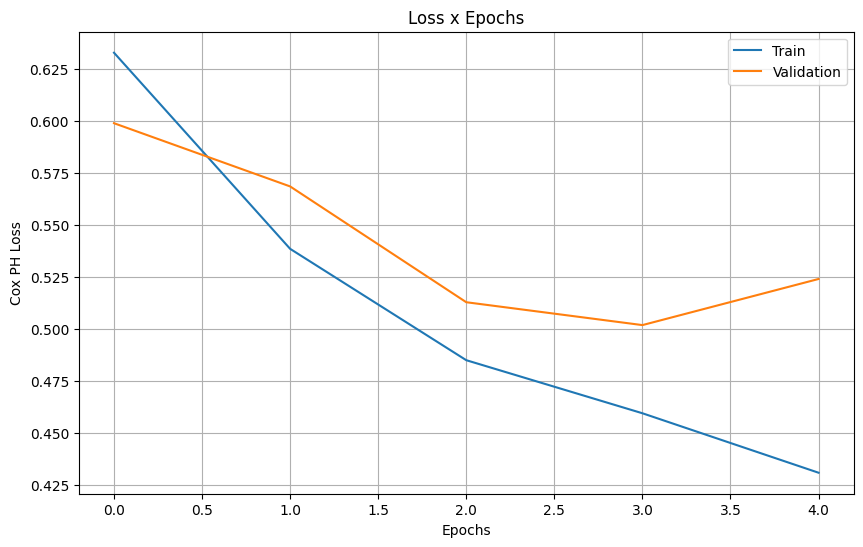

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss x Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cox PH Loss')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
test(dataloader_test, device)

test accuracy: 75.0% | test loss: 0.5259


In [68]:
example_texts = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "It was a complete waste of time. I wouldn't recommend it to anyone.",
    "The acting was fantastic, and the plot was nice.",
    "Absolutely horrible experience, never again."
]

encoded_inputs = tokenizer(
    example_texts,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

input_ids = encoded_inputs['input_ids'].to(device)
attention_mask = encoded_inputs['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask).squeeze(1)
    probabilities = torch.sigmoid(outputs)
    predictions = (probabilities > 0.5).long()

for i, text in enumerate(example_texts):
    sentiment = "POSITIVE" if predictions[i].item() == 1 else "NEGATIVE"
    print(f"Review: '{text}'")
    print(f"Predicted Sentiment: {sentiment} (Probability: {probabilities[i].item():.4f})\n")

Review: 'This movie was absolutely fantastic! I loved every minute of it.'
Predicted Sentiment: POSITIVE (Probability: 0.9092)

Review: 'It was a complete waste of time. I wouldn't recommend it to anyone.'
Predicted Sentiment: NEGATIVE (Probability: 0.0876)

Review: 'The acting was fantastic, and the plot was nice.'
Predicted Sentiment: POSITIVE (Probability: 0.7310)

Review: 'Absolutely horrible experience, never again.'
Predicted Sentiment: NEGATIVE (Probability: 0.1775)

